# Regression

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.formula.api as sm
import statsmodels.api as sma
import seaborn as sns

In [24]:
db = pd.read_csv("data/player_stats_extended.csv")

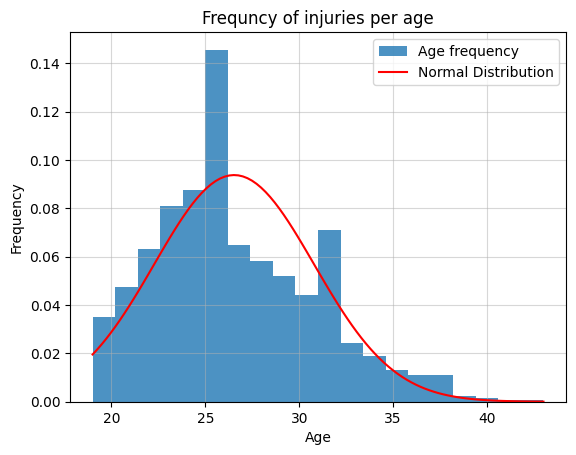

In [25]:
age = db["AGE"]

mu, sigma = np.mean(age), np.std(age)
x = np.linspace(age.min(), age.max(), 100)

plt.grid(alpha=0.5)
plt.hist(age, bins=20, density=True, alpha=0.8, label='Age frequency')
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', label='Normal Distribution')
plt.title("Frequncy of injuries per age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.show()

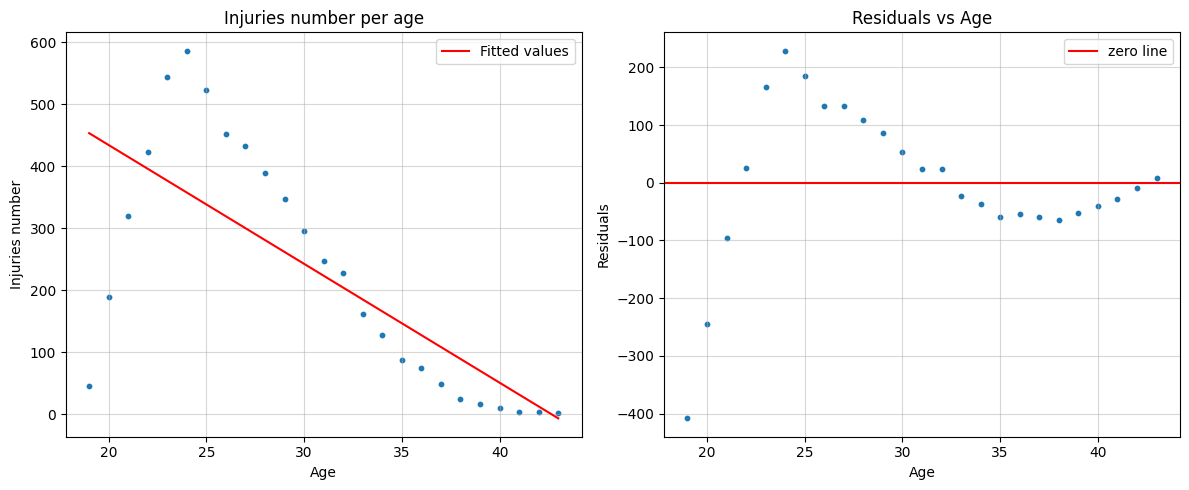

                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     25.50
Date:                 Do, 01 Mai 2025   Prob (F-statistic):           4.12e-05
Time:                        10:12:17   Log-Likelihood:                -157.40
No. Observations:                  25   AIC:                             318.8
Df Residuals:                      23   BIC:                             321.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    817.1754    120.777      6.766      0.0

In [26]:
injuries_age = pd.DataFrame([
    {
    'Age': int(a), 
    'injuries_number': len(db[db["AGE"] == a])
    }
    for a in sorted(db["AGE"].unique())
])

res = sm.ols('injuries_number ~ Age', data=injuries_age).fit()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Regression plot
ax1.grid(alpha=0.5)
ax1.scatter(injuries_age['Age'], injuries_age['injuries_number'], s=10)
x = np.linspace(age.min(), age.max(), len(injuries_age))
ax1.plot(x, res.fittedvalues, 'r-', label='Fitted values')
ax1.legend()
ax1.set_title("Injuries number per age")
ax1.set_xlabel("Age")
ax1.set_ylabel("Injuries number")

# Residuals plot
residuals = res.resid
ax2.grid(alpha=0.5)
ax2.scatter(injuries_age['Age'], residuals, s=10)
ax2.axhline(y=0, color='r', linestyle='-', label='zero line')
ax2.set_title("Residuals vs Age")
ax2.set_xlabel("Age")
ax2.set_ylabel("Residuals")
ax2.legend()

plt.tight_layout()
plt.show()

print(res.summary())

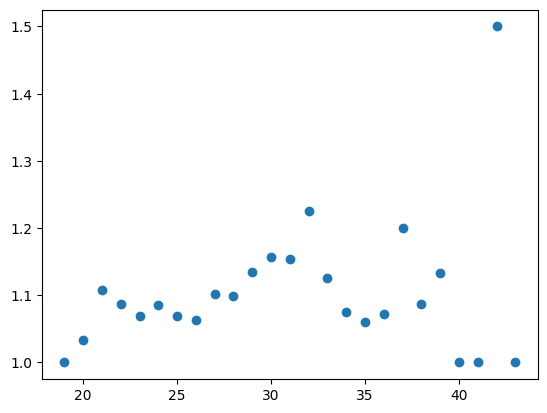

    Age  injuries_number  unique_players
0    19               45              45
1    20              189             183
2    21              319             288
3    22              422             388
4    23              543             508
5    24              586             540
6    25              523             489
7    26              452             425
8    27              433             393
9    28              389             354
10   29              347             306
11   30              296             256
12   31              247             214
13   32              228             186
14   33              162             144
15   34              128             119
16   35               87              82
17   36               74              69
18   37               48              40
19   38               25              23
20   39               17              15
21   40               10              10
22   41                4               4
23   42         

In [27]:
injuries_age = pd.DataFrame([
    {
        'Age': int(a),
        'injuries_number': len(db[db["AGE"] == a]),
        'unique_players': len(db[db["AGE"] == a]["PLAYER_ID"].unique())
    }
    for a in sorted(db["AGE"].unique())
])

plt.scatter(injuries_age['Age'], injuries_age['injuries_number']/injuries_age['unique_players'])
plt.show()

print(injuries_age)


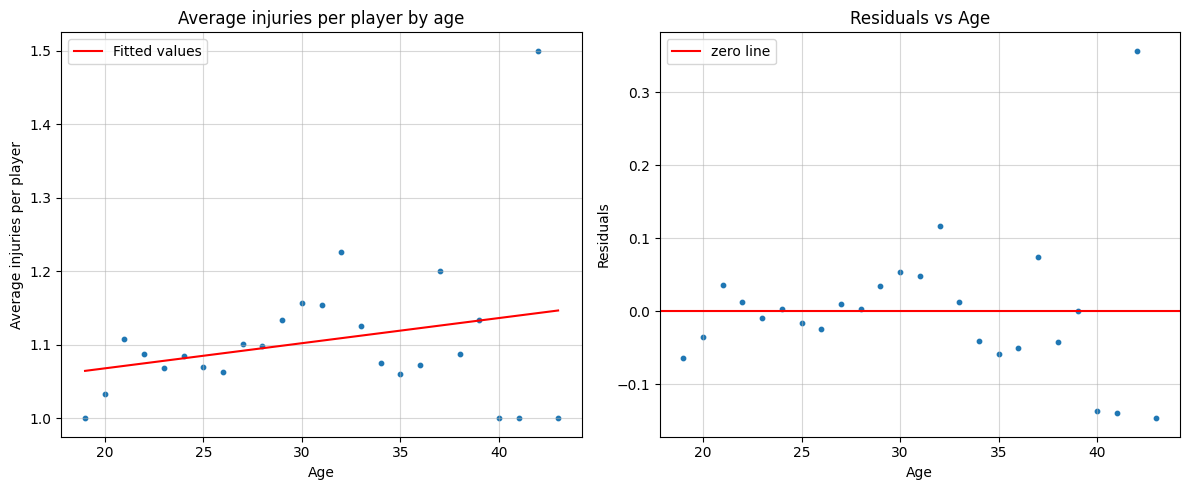

                            OLS Regression Results                            
Dep. Variable:         injuries_ratio   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.522
Date:                 Do, 01 Mai 2025   Prob (F-statistic):              0.230
Time:                        10:12:18   Log-Likelihood:                 23.132
No. Observations:                  25   AIC:                            -42.26
Df Residuals:                      23   BIC:                            -39.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9995      0.088     11.322      0.0

In [28]:
injuries_age_stats = pd.DataFrame({
    'Age': injuries_age['Age'],
    'injuries_ratio': injuries_age['injuries_number']/injuries_age['unique_players']
})
res = sm.ols('injuries_ratio ~ Age', data=injuries_age_stats).fit()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Regression plot
ax1.grid(alpha=0.5)
ax1.scatter(injuries_age['Age'], injuries_age['injuries_number']/injuries_age['unique_players'], s=10)
x = np.linspace(injuries_age['Age'].min(), injuries_age['Age'].max(), len(injuries_age))
ax1.plot(x, res.fittedvalues, 'r-', label='Fitted values')
ax1.legend()
ax1.set_title("Average injuries per player by age")
ax1.set_xlabel("Age")
ax1.set_ylabel("Average injuries per player")

# Residuals plot
residuals = res.resid
ax2.grid(alpha=0.5)
ax2.scatter(injuries_age['Age'], residuals, s=10)
ax2.axhline(y=0, color='r', linestyle='-', label='zero line')
ax2.set_title("Residuals vs Age")
ax2.set_xlabel("Age")
ax2.set_ylabel("Residuals")
ax2.legend()

plt.tight_layout()
plt.show()

print(res.summary())

In [29]:
# Convert height and weight directly to numeric without string operations
db['PLAYER_HEIGHT_INCHES'] = pd.to_numeric(db['PLAYER_HEIGHT_INCHES'], errors='coerce')
db['PLAYER_WEIGHT'] = pd.to_numeric(db['PLAYER_WEIGHT'], errors='coerce')

# Create DataFrame with all variables for multiple regression
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[db["AGE"] == a]),
        'Age': int(a),
        'height': db[db["AGE"] == a]["PLAYER_HEIGHT_INCHES"].mean(),
        'weight': db[db["AGE"] == a]["PLAYER_WEIGHT"].mean(),
    }
    for a in sorted(db["AGE"].unique())
])

# Perform multiple regression
res_multiple = sm.ols('injuries_number ~ Age + height + weight', data=injuries_multiple).fit()

print(res_multiple.summary())


                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     15.50
Date:                 Do, 01 Mai 2025   Prob (F-statistic):           1.52e-05
Time:                        10:12:18   Log-Likelihood:                -152.13
No. Observations:                  25   AIC:                             312.3
Df Residuals:                      21   BIC:                             317.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.414e+04   4346.373      3.253      0.0

In [30]:
# Convert height and weight directly to numeric without string operations
db['PLAYER_HEIGHT_INCHES'] = pd.to_numeric(db['PLAYER_HEIGHT_INCHES'], errors='coerce')
db['PLAYER_WEIGHT'] = pd.to_numeric(db['PLAYER_WEIGHT'], errors='coerce')

# Create DataFrame with all variables for multiple regression
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[db["AGE"] == a]),
        'Age': int(a),
        'height': db[db["AGE"] == a]["PLAYER_HEIGHT_INCHES"].mean(),
        'weight': db[db["AGE"] == a]["PLAYER_WEIGHT"].mean(),
        'games_played': db[db["AGE"] == a]["GP"].sum()
    }
    for a in sorted(db["AGE"].unique())
])

# Perform multiple regression
res_multiple = sm.ols('injuries_number ~ Age + height + weight + games_played', data=injuries_multiple).fit()

print(res_multiple.summary())


                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     321.4
Date:                 Do, 01 Mai 2025   Prob (F-statistic):           7.72e-18
Time:                        10:12:18   Log-Likelihood:                -114.49
No. Observations:                  25   AIC:                             239.0
Df Residuals:                      20   BIC:                             245.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -729.8401   1244.740     -0.586   

In [31]:
# Convert height and weight directly to numeric without string operations
db['PLAYER_HEIGHT_INCHES'] = pd.to_numeric(db['PLAYER_HEIGHT_INCHES'], errors='coerce')
db['PLAYER_WEIGHT'] = pd.to_numeric(db['PLAYER_WEIGHT'], errors='coerce')
db['DIST_MILES'] = pd.to_numeric(db['DIST_MILES'], errors='coerce')
db['PACE'] = pd.to_numeric(db['PACE'], errors='coerce')
db['AVG_SPEED'] = pd.to_numeric(db['AVG_SPEED'], errors='coerce')

# Create DataFrame with all variables for multiple regression
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[db["AGE"] == a]),
        'games_played': db[db["AGE"] == a]["GP"].sum(),
        'days_missed': db[db["AGE"] == a]["DAYS MISSED"].sum(),
        'pace': db[db["AGE"] == a]["PACE"].mean(),
        'dist_miles': db[db["AGE"] == a]["DIST_MILES"].mean(),
        'avg_speed': db[db["AGE"] == a]["AVG_SPEED"].mean(),
    }
    for a in sorted(db["AGE"].unique())
])

# Perform multiple regression
res_multiple = sm.ols('injuries_number ~ games_played + days_missed + pace + dist_miles + avg_speed', data=injuries_multiple).fit()

print(res_multiple.summary())


                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     600.4
Date:                 Do, 01 Mai 2025   Prob (F-statistic):           3.21e-20
Time:                        10:12:18   Log-Likelihood:                -103.36
No. Observations:                  25   AIC:                             218.7
Df Residuals:                      19   BIC:                             226.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      588.2036    301.308      1.952   

In [32]:
# Create DataFrame with all variables for multiple regression
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[db["AGE"] == a]),
        'games_played': db[db["AGE"] == a]["GP"].sum(),
        'pace': db[db["AGE"] == a]["PACE"].mean(),
        'dist_miles': db[db["AGE"] == a]["DIST_MILES"].mean(),
    }
    for a in sorted(db["AGE"].unique())
])

# Perform multiple regression
res_multiple = sm.ols('injuries_number ~ games_played + pace + dist_miles', data=injuries_multiple).fit()

print(res_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     749.8
Date:                 Do, 01 Mai 2025   Prob (F-statistic):           1.66e-21
Time:                        10:12:18   Log-Likelihood:                -108.18
No. Observations:                  25   AIC:                             224.4
Df Residuals:                      21   BIC:                             229.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      839.8326    330.982      2.537   

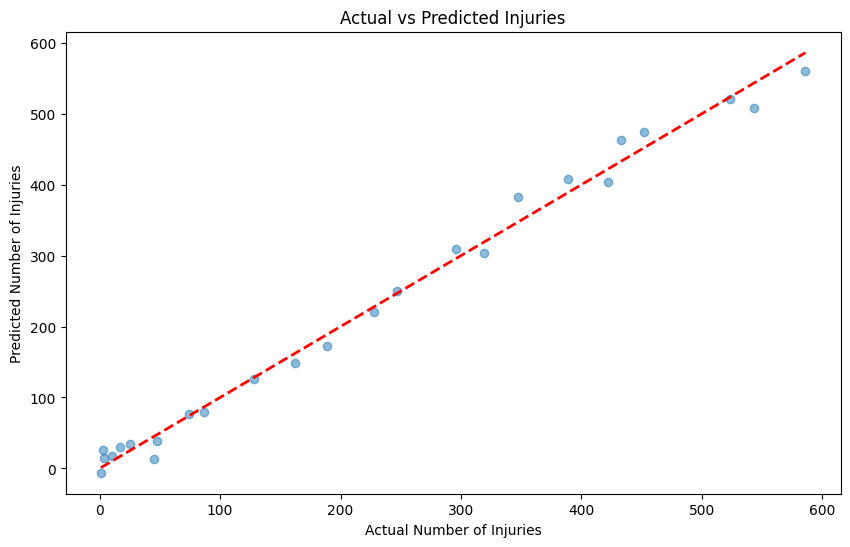

In [33]:
def plot_mult_reg(res_multiple):
    # Create visualization of actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(injuries_multiple['injuries_number'], res_multiple.fittedvalues, alpha=0.5)
    plt.plot([injuries_multiple['injuries_number'].min(), injuries_multiple['injuries_number'].max()], 
            [injuries_multiple['injuries_number'].min(), injuries_multiple['injuries_number'].max()], 
            'r--', lw=2)
    plt.xlabel('Actual Number of Injuries')
    plt.ylabel('Predicted Number of Injuries')
    plt.title('Actual vs Predicted Injuries')
    plt.show()

plot_mult_reg(res_multiple)

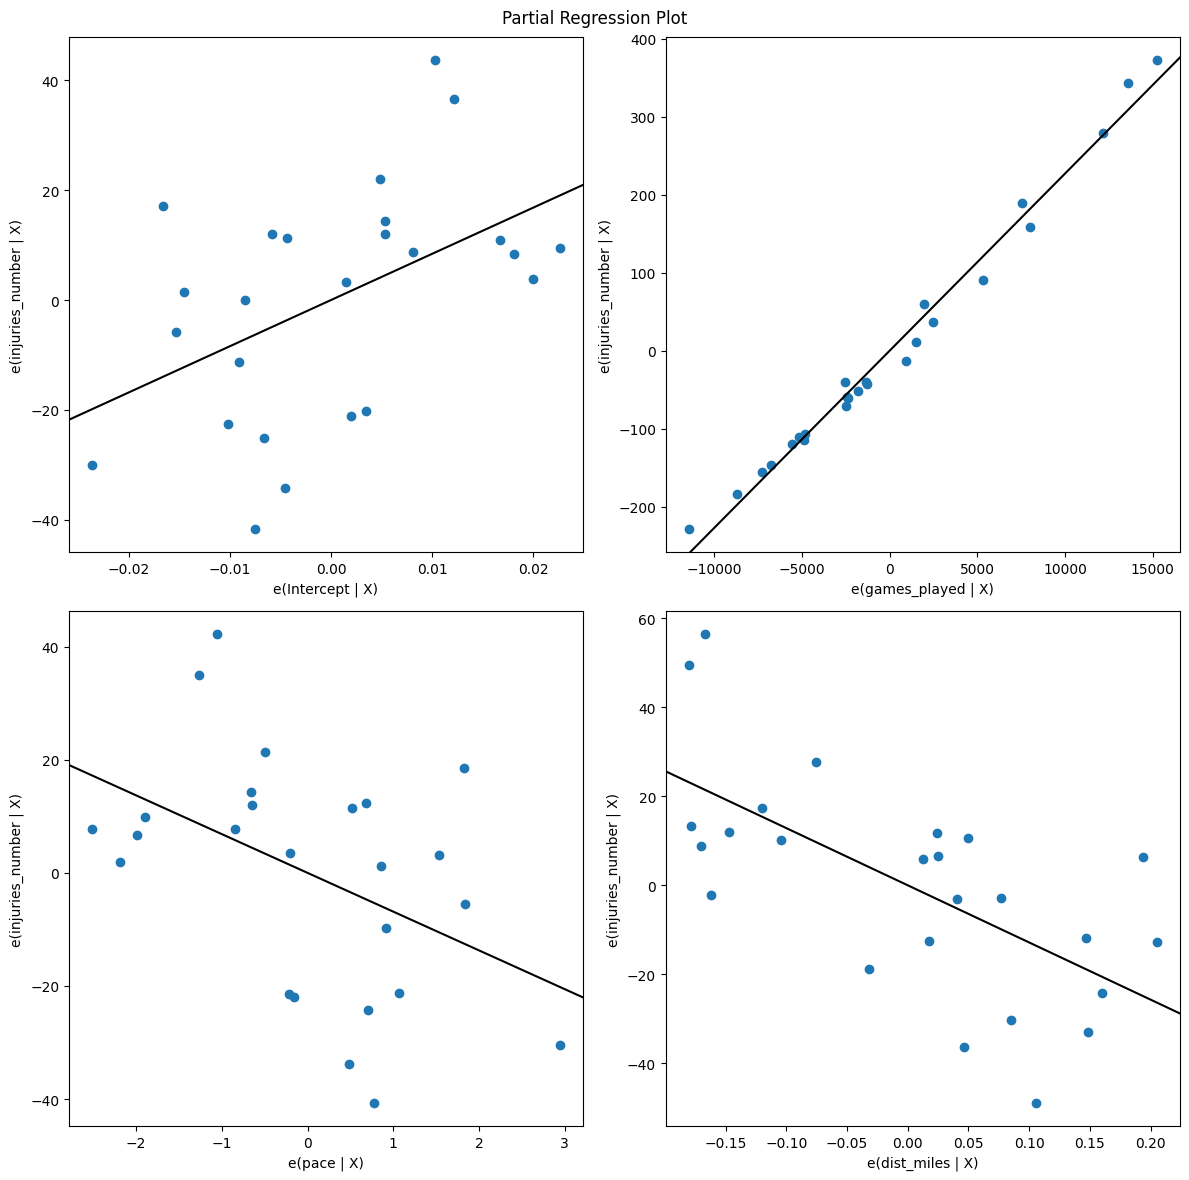

In [34]:
def plot_part_reg(res_multiple):
    # Create partial regression plots
    fig = plt.figure(figsize=(12, 12))
    sma.graphics.plot_partregress_grid(res_multiple, fig=fig)
    plt.tight_layout()
    plt.show()

plot_part_reg(res_multiple)

In [35]:
# Create DataFrame with all variables for multiple regression
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[db["AGE"] == a]),
        'games_played': db[db["AGE"] == a]["GP"].sum(),
        'minutes': db[db["AGE"] == a]["MIN"].mean(),
    }
    for a in sorted(db["AGE"].unique())
])

# Perform multiple regression
res_multiple = sm.ols('injuries_number ~ games_played + minutes', data=injuries_multiple).fit()

print(res_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     982.9
Date:                 Do, 01 Mai 2025   Prob (F-statistic):           3.05e-22
Time:                        10:12:19   Log-Likelihood:                -110.43
No. Observations:                  25   AIC:                             226.9
Df Residuals:                      22   BIC:                             230.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       78.7594     25.305      3.112   

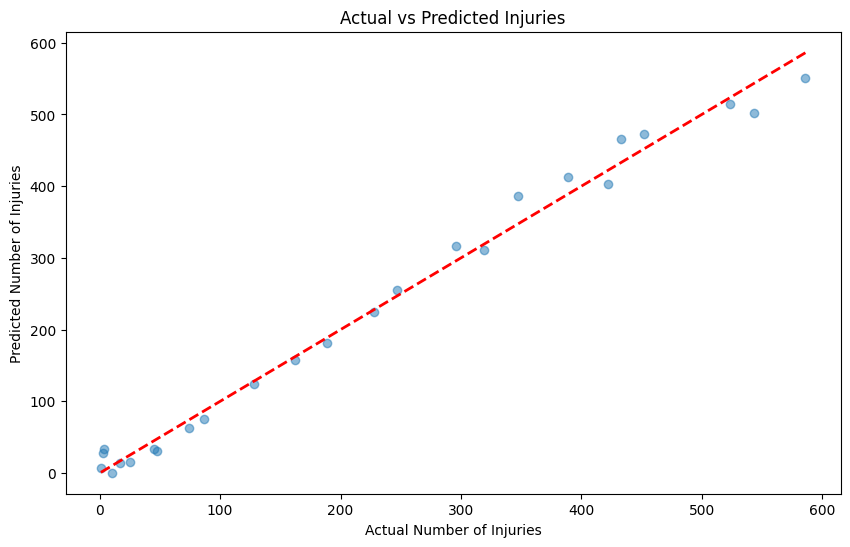

In [36]:
plot_mult_reg(res_multiple)

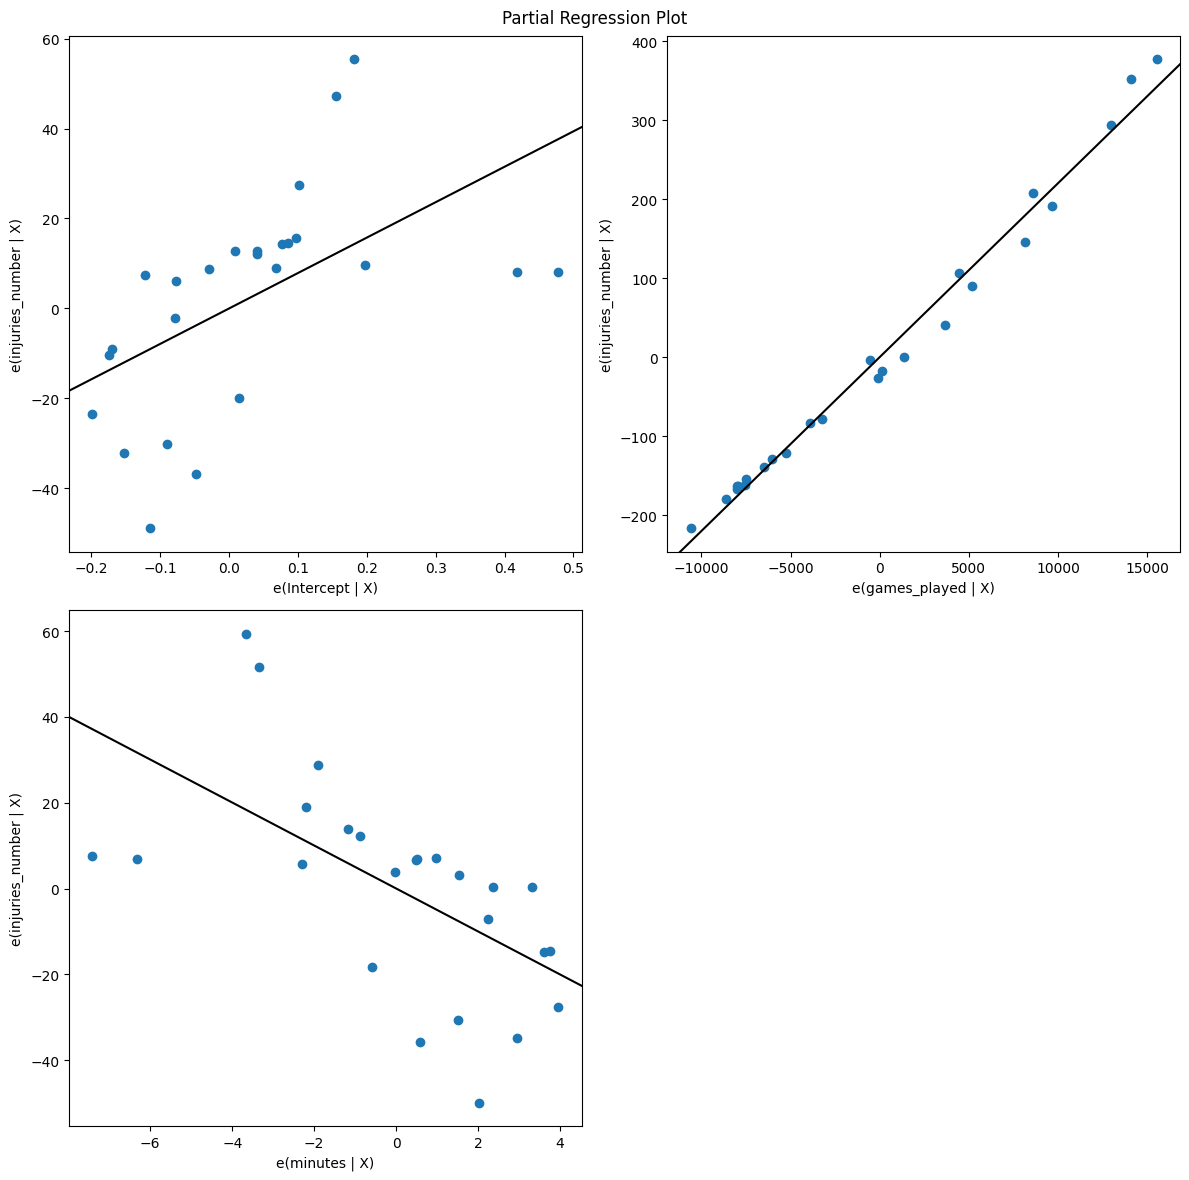

In [37]:
plot_part_reg(res_multiple)

- if older players have a longer recovery time

- split by type of injury and see if predictors are different

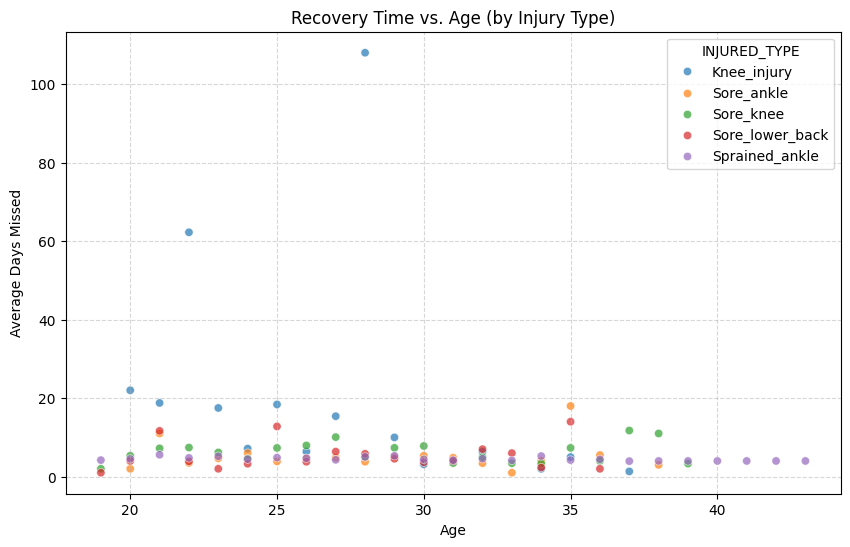

In [41]:
age_recoverytime = db[["AGE", "DAYS MISSED", "INJURED_TYPE"]].copy()
recovery_by_age_and_type = age_recoverytime.groupby(['INJURED_TYPE', 'AGE'])['DAYS MISSED'].mean().reset_index()

age_recoverytime.head()

plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(
    data=recovery_by_age_and_type,
    x='AGE',
    y='DAYS MISSED',
    hue='INJURED_TYPE',
    alpha=0.7  # Adjust transparency for better readability
)

# Add title and labels
plt.title("Recovery Time vs. Age (by Injury Type)")
plt.xlabel("Age")
plt.ylabel("Average Days Missed")

# Show grid for better visualization
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.show()









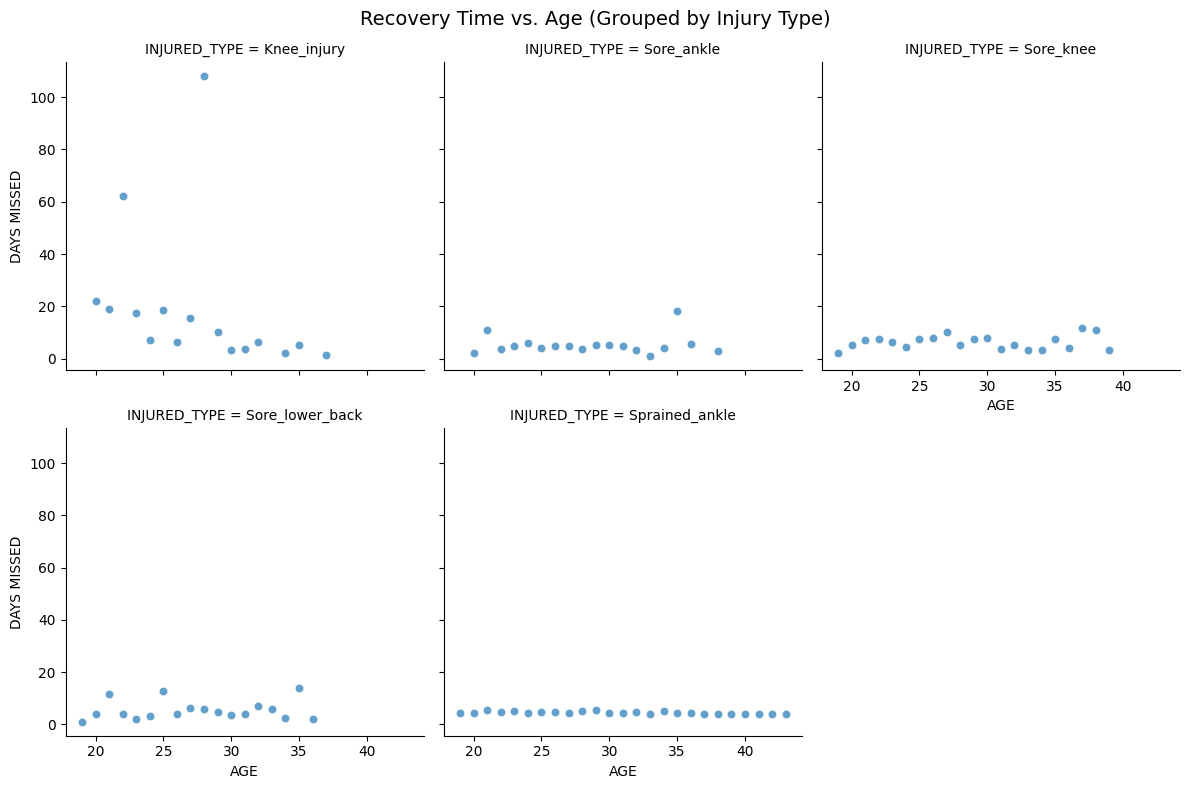

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the FacetGrid with each injury type as a separate plot
g = sns.FacetGrid(recovery_by_age_and_type, col="INJURED_TYPE", col_wrap=3, height=4, sharex=True, sharey=True)

# Map scatter plots onto each subplot
g.map_dataframe(sns.scatterplot, x="AGE", y="DAYS MISSED", alpha=0.7)

# Add title to the overall figure
g.fig.suptitle("Recovery Time vs. Age (Grouped by Injury Type)", fontsize=14)

# Adjust layout
g.tight_layout()

# Show the plots
plt.show()

In [47]:
#split by type of injury and see if predictors are different: 

Knee_injury_Predictors = db[db["INJURED_TYPE"]=="Knee_injury"]
Knee_injury_Predictors.drop(["PLAYER_ID", "PLAYER_NAME", "SEASON", "TEAM", "INJURED ON", "RETURNED", "INJURY_SEVERITY", "Injury_Severity"], axis=1, inplace=True)
Knee_injury_Predictors.head()

res_multiple = sm.ols('INJURED_TYPE ~ SEASON_NUM + AGE + PLAYER_HEIGHT_INCHES + PLAYER_WEIGHT + GP + MIN + USG_PCT + PACE + POSS + FGA_PG + DRIVES + DRIVE_FGA + DRIVE_PASSES + DIST_MILES + AVG_SPEED + PULL_UP_FGA + PULL_UP_FG3A + TOUCHES + FRONT_CT_TOUCHES + AVG_SEC_PER_TOUCH + AVG_DRIB_PER_TOUCH + ELBOW_TOUCHES + POST_TOUCHES + PAINT_TOUCHES + DAYS MISSED + INJURED_TYPE', data=injuries_multiple).fit()

print(res_multiple.summary())
 


C:\Users\levas\AppData\Local\Temp\ipykernel_10980\4218319529.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Knee_injury_Predictors.drop(["PLAYER_ID", "PLAYER_NAME", "SEASON", "TEAM", "INJURED ON", "RETURNED", "INJURY_SEVERITY", "Injury_Severity"], axis=1, inplace=True)


SyntaxError: invalid syntax (<unknown>, line 1)